In [15]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize_scalar, minimize
from pandas.plotting import register_matplotlib_converters

In [65]:
# 환경설정
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
register_matplotlib_converters()

## 목차
1. 개요
  1. 이론
    * Nelson-Siegel
    * Dynamic Nelson-Siegel
    * Smith-Wilson
    * Kalman Filter
    * Gradient Descent 
  2. 산출 프로세스의 구성
2. 데이터
3. 초기값 설정
  1. 개요
  2. 이론
  3. 산출값
4. 모수 추정
  1. 개요
  2. 산출값
5. 시나리오 생성
  1. 결정론적 시나리오
  2. 확률론적 시나리오
6. 보간/보외 등
  1. 변동성 조정
  2. UFR, α

## 1. 개요
---

제1장에서는 내부모형 산출방법을 이해하기 위해 먼저 숙지해야 할 이론들에 대해 알아본다.  
산출 프로세스의 구성에 대해서도 간단히 짚어본다.

### A. 이론

#### Nelson-Siegel Model
---

일별 시장금리는 [금융투자협회 채권정보센터](http://www.kofiabond.or.kr/) 등에 공시되는데, 모든 만기에 대해 공시되진 않고 3개월, 6개월, 9월, ..., 30년, 50년 이렇게 불연속적이다.  
**`Nelson-Siegel Model`**은 이러한 불연속적인 만기별 금리를 연속적으로 확장시켜주는 모형이다.  
이 모형은 추후에 설명할 **`Smith-Wilson Method`**와 다르게 모형값이 실제값과 일치하지 않는다.  

**`Nelson-Siegel Model`**은 만기($t$)별 금리($r_t$)를 다음과 같이 표현한다.

\begin{align}
    r_{\tau}=\beta_1+\beta_2(\frac{1-e^{-\lambda\tau}}{\lambda\tau})+\beta_3(\frac{1-e^{-\lambda\tau}}{\lambda\tau}-e^{-\lambda\tau}), \tau \geq 0
\end{align}

여기서 추정해야 하는 모수는 $(\lambda$, $\beta_1, \beta_2, \beta_3)$이다.  

#### 모수 추정
---

모수는 최소자승법(Least Square Method)을 이용해 추정한다.  
즉, MSE(Mean Suared Error)를 손실(Loss)로 하고, 손실을 모수에 대한 함수로 구성한 후, 손실이 최소가 되는 모수를 찾는 방법(최적화)으로 추정한다.  
원칙적으로 손실함수는 모수에 대해 비선형이기 때문에 다변수함수의 최적화 알고리즘을 사용해야 한다.  
하지만 $\lambda$를 고정시키면 선형화 되어, 다음과 같은 방법을 많이 사용한다.

\begin{align}
    \vec{r} &= (r_{1}, r_{2}, r_{3}, r_{5}, r_{10}, r_{20})^{T} \\
    H &= H(\lambda) = ...\\
    \vec{\beta} &= (\beta_1, \beta_2, \beta_3)^{T} = \beta(\lambda) = (H^{T}H)^{-1}H^{T}\vec{r} \\
    \epsilon &= \epsilon(\lambda) = \sqrt{\|y-H\vec{\beta}\|^{2}} \\
    \\
    \hat{\lambda} &= \min_{\lambda}{\epsilon(\lambda)} \\
    \hat{H} &= ...\\
    \vec{\hat{\beta}} &= (\hat{H}^{T}\hat{H})^{-1}\hat{H}^{T}\vec{r} \\
\end{align}

물론 다음과 같이 손실($\epsilon$)을 최소화 시키는 것도 가능하나 차이는 별로 없다.

\begin{align}
    \hat{\lambda}, \hat{\vec{\beta}} = \min_{\lambda, \vec{\beta}}{\epsilon(\lambda, \vec{\beta})}
\end{align}

In [6]:
# 데이터 로드 및 가공
data = pd.read_excel('./data/D_Bond_Mark_to_Mkt_Benchmark_Yields_TS_200409142736.xlsx')
data.columns = data.iloc[2].values
data = data.iloc[3:].reset_index(drop=True).sort_values(by='일자')
data['일자'] = data['일자'].apply(lambda x: datetime.strptime(x, '%Y.%m.%d'))
data = data[['일자', '12개월', '24개월', '3년', '5년', '10년', '20년']].set_index('일자').astype(float)
data.columns = ['1년', '2년', '3년', '5년', '10년', '20년']
maturity = data.columns.str.replace('년', '').astype(int)

In [129]:
y = data.iloc[-1].values
lambda_ = 0.7071
H = np.array([[1, (1-np.exp(-lambda_*tau))/(lambda_*tau), (1-np.exp(-lambda_*tau))/(lambda_*tau)-np.exp(-lambda_*tau)] for tau in maturity])
beta = np.linalg.inv(H.T@H)@H.T@y

# λ 추정 → β 추정
def obj_func_ns(lambda_):
    y = data.iloc[-1].values
    H = np.array([[1, (1-np.exp(-lambda_*tau))/(lambda_*tau), (1-np.exp(-lambda_*tau))/(lambda_*tau)-np.exp(-lambda_*tau)] for tau in maturity])
    beta = np.linalg.inv(H.T@H)@H.T@y
    return np.sqrt(np.sum((H@beta-y)**2))
lambda_opt = minimize_scalar(obj_func_ns, method='bounded', bounds=[0,1]).x
H_opt = np.array([[1, (1-np.exp(-lambda_opt*tau))/(lambda_opt*tau), (1-np.exp(-lambda_opt*tau))/(lambda_opt*tau)-np.exp(-lambda_opt*tau)] for tau in maturity])
beta_opt = np.linalg.inv(H_opt.T@H_opt)@H_opt.T@y

# λ, β 동시 추정
def obj_func_ns_v2(params):
    lambda_, beta1, beta2, beta3 = params
    beta = np.array([beta1, beta2, beta3])
    y = data.iloc[-1].values
    H = np.array([[1, (1-np.exp(-lambda_*tau))/(lambda_*tau), (1-np.exp(-lambda_*tau))/(lambda_*tau)-np.exp(-lambda_*tau)] for tau in maturity])
    beta = np.linalg.inv(H.T@H)@H.T@y
    return np.sqrt(np.sum((H@beta-y)**2))
lambda_opt_v2, beta1_opt_v2, beta2_opt_v2, beta3_opt_v2 = minimize(obj_func_ns_v2, np.array([0.5, 1, 1, 1])).x
H_opt_v2 = np.array([[1, (1-np.exp(-lambda_opt_v2*tau))/(lambda_opt_v2*tau), (1-np.exp(-lambda_opt_v2*tau))/(lambda_opt_v2*tau)-np.exp(-lambda_opt_v2*tau)] for tau in maturity])
beta_opt_v2 = np.linalg.inv(H_opt_v2.T@H_opt_v2)@H_opt_v2.T@y

# Nelson-Siegel 함수
def NelsonSiegel(maturity, lambda_, beta):
    H = np.array([[1, (1-np.exp(-lambda_*tau))/(lambda_*tau), (1-np.exp(-lambda_*tau))/(lambda_*tau)-np.exp(-lambda_*tau)] for tau in maturity])
    return H@beta

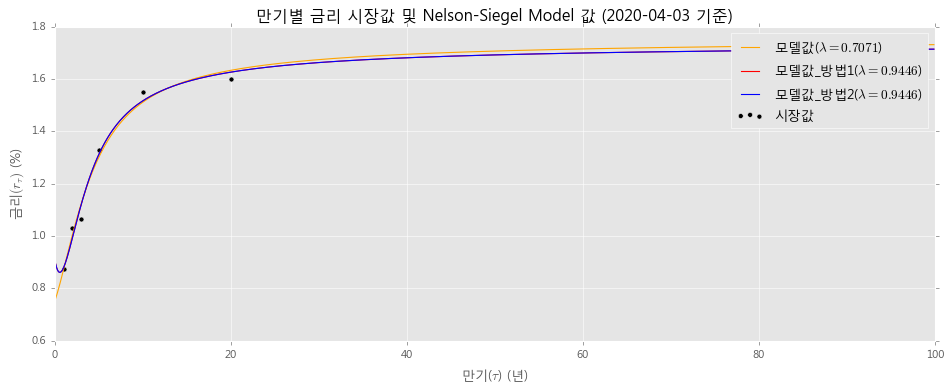

In [130]:
# 만기별 금리 시각화
fig, ax = plt.subplots(1,1, figsize=(12,5))

x_range = np.arange(0.1, 100, 0.1)
ax.scatter(maturity, data.iloc[-1].values, c='black', label='시장값')
ax.plot(x_range, NelsonSiegel(x_range, 0.7071, beta), 'orange', label='모델값($\lambda={:.4f}$)'.format(0.7071))
ax.plot(x_range, NelsonSiegel(x_range, lambda_opt, beta_opt), 'red', label='모델값_방법1($\lambda={:.4f}$)'.format(lambda_opt))
ax.plot(x_range, NelsonSiegel(x_range, lambda_opt_v2, beta_opt_v2), 'blue', label='모델값_방법2($\lambda={:.4f}$)'.format(lambda_opt_v2))
ax.set_xlabel('만기($\\tau$) (년)')
ax.set_ylabel('금리$(r_\\tau)$ (%)')
ax.set_title('만기별 금리 시장값 및 Nelson-Siegel Model 값 ({} 기준)'.format(data.iloc[-1].name.strftime('%Y-%m-%d')))
ax.set_xlim(0, 100)
ax.legend()

plt.tight_layout()
plt.show()

#### Dynamic Nelson-Siegel(DNS) Model
---

**`Nelson-Siegel Model`**은 특정 날짜의 불연속적 시장금리를 모든 만기($t \geq 0$)에 대한 금리로 확장 시켜주는 모형이다. 다시 말하면, 같은 날짜의 시장금리를 확장시켜줄 뿐이지, 미래의 만기별 금리를 예측하는 모형은 아니다. 이 모형에 의한 만기별 금리(금리기간구조)는 4개의 모수($\lambda, \vec{\beta}$)로 완전히 결정된다.

**`DNS Model`**은 **`Nelson-Siegel Model`**의 $\vec{\beta}$가 시간에 따라 변한다고 보고, 다음과 같은 동적계(Dynamical System)를 상정한다($\lambda$는 상수로 고정).  

\begin{align}
    d\vec{\beta}_{t} &= K(\vec{\theta}-\vec{\beta}_{t})dt+\Sigma d\vec{W}_{t} \\
    \vec{r}_{t} &= H\vec{\beta}_{t}+\vec{\epsilon}_{t}
\end{align}

여기서 추정해야 하는 모수는 $(\lambda, \epsilon, \kappa_{1}, \kappa_{2}, \kappa_{3}, \theta_{1}, \theta_{2}, \theta_{3}, \sigma_{11}, \sigma_{21}, \sigma_{22}, \sigma_{31}, \sigma_{32}, \sigma_{33})$이다.

#### 금리시나리오
---

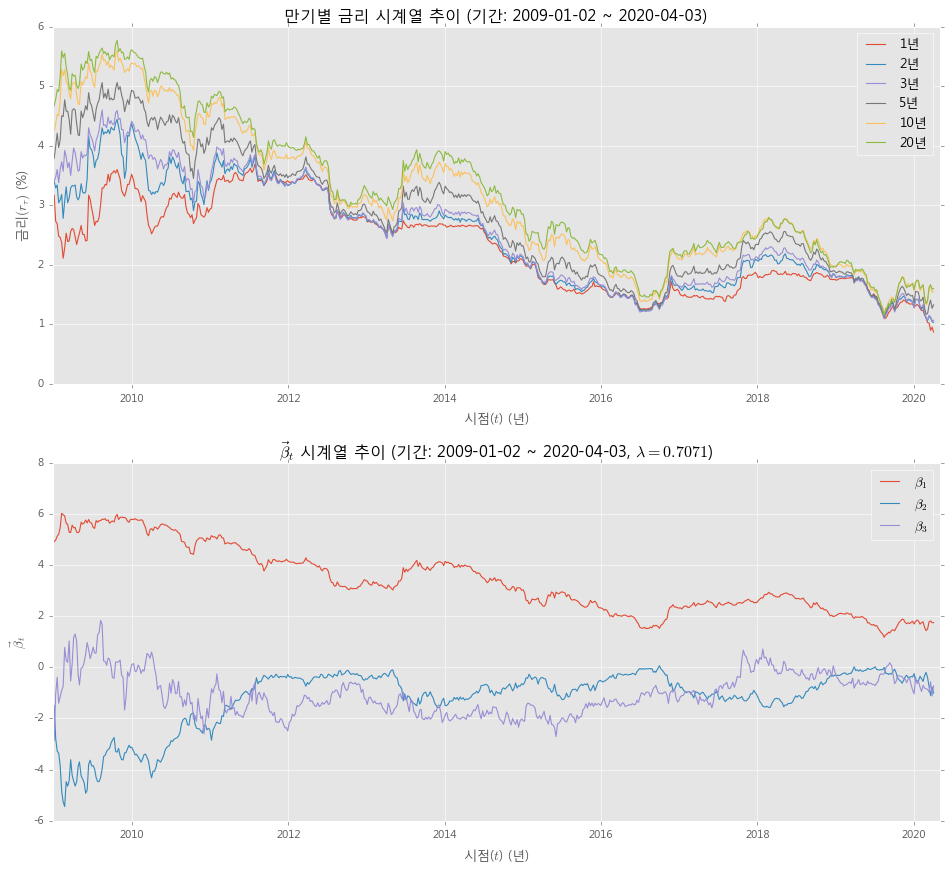

In [134]:
# 시점별 금리 시각화
fig, ax = plt.subplots(2,1, figsize=(12,11))

# 금리
for mat in data.columns:
    ax[0].plot(data[mat], label=mat)
ax[0].set_title('만기별 금리 시계열 추이 (기간: {} ~ {})'.format(data.index[0].strftime('%Y-%m-%d'), data.index[-1].strftime('%Y-%m-%d')))
ax[0].set_xlim(data.index[0] + pd.Timedelta(weeks=-1), data.index[-1] + pd.Timedelta(weeks=+4))
ax[0].legend()
ax[0].set_xlabel('시점($t$) (년)')
ax[0].set_ylabel('금리$(r_{\\tau})$ (%)')

# 베타
H = np.array([[1, (1-np.exp(-lambda_*tau))/(lambda_*tau), (1-np.exp(-lambda_*tau))/(lambda_*tau)-np.exp(-lambda_*tau)] for tau in maturity])
beta = (np.linalg.inv(H.T@H)@H.T@np.array(data).T).T
beta = pd.DataFrame(beta, columns=['$\\beta_1$', '$\\beta_2$', '$\\beta_3$'], index=data.index)
for i in beta.columns:
    ax[1].plot(beta[i], label=i)
ax[1].set_title('$\\vec\\beta_t$ 시계열 추이 (기간: {} ~ {}, $\lambda=0.7071$)'.format(beta.index[0].strftime('%Y-%m-%d'), beta.index[-1].strftime('%Y-%m-%d')))
ax[1].set_xlim(beta.index[0] + pd.Timedelta(weeks=-1), beta.index[-1] + pd.Timedelta(weeks=+4))
ax[1].legend()
ax[1].set_xlabel('시점($t$) (년)')
ax[1].set_ylabel('$\\vec\\beta_t$')

plt.tight_layout()
plt.show()

#### Kalman Filter
---

**`Kalman Filter`**는 잡음(Noise)이 포함되어 있는 측정치(Measurement)를 바탕으로 선형 역학계의 상태(State)를 추정하는 재귀 필터로, 헝가리계 미국인 Rudolf E. Kalman이 개발하였다. 선형 역학계의 상태 및 측정은 다음의 방정식으로 이루어진다고 가정한다.

\begin{align}
    \vec{x}_{k} &= A\vec{x}_{k-1}+\vec{b}+\vec{\eta}_{k} \\
    \vec{z}_{k} &= H\vec{x}_{k}+\vec{\epsilon}_{k}
\end{align}


각 추정 계산은 예측과 보정 두 단계로 이루어진다. 예측은 이전 시간에 추정된 상태에 대해, 그 다음 시간에 예상되는 측정값을 계산한다. 보정은 앞서 예측된 측정값과 실제 측정값을 토대로 현재 상태를 추정한다.

#### 예측 단계
\begin{align}
    \vec{x}_{k|k-1} &= A\vec{x}_{k-1|k-1} + \vec{b} \\
    P_{k|k-1} &= AP_{k-1|k-1}A^{T} + Q
\end{align}

#### 보정 단계
\begin{align}
    \vec{y}_{k} &= \vec{z}_{k} - H\vec{x} \\
    S_{k} &= HP_{k|k-1}H^{T} + R \\
    K_{k} &= P_{k|k-1}H^{T}S^{-1}_{k} \\
    \vec{x}_{k|k} &= \vec{x}_{k|k-1} + K_{k}\vec{y}_{k} \\
    P_{k|k} &= (I-K_{k}H)P_{k|k-1}
\end{align}

**`Kalman Filter`**를 이용해 상태를 추정하기 위해선 선형 역학계가 사전에 주어져야 하는데, 보통 선험적으로 주어진 역학계가 존재하지 않기 때문에, 이 또한 추정해야 한다. 즉, $\{A, \vec{b}, Q, H, R\}$를 추정해야 한다.

#### 로그 우도
역학계가 모수 벡터($\vec{\phi}$)로 표현될 수 있을 때, log-likelihood는 다음과 같다.
\begin{align}
    l(z_{1}, z_{2}, ..., z_{N};\vec{\phi})= \sum_{k=1}^{N}{(-\frac{M}{2}ln(2\pi)-\frac{1}{2}ln(det(S_{k}))-\frac{1}{2}y_{k}^{T}S_{k}^{-1}y_{k})}
\end{align}

여기서, $M$은 각 측정되는  데이터(벡터) 1개의 차원이고, $N$은 데이터 측정 횟수이다.

#### 로그 우도의 그래디언트

#### DNS Model과의 관계
---

#### Gradient Descent
---
**`Gradient Descent`**는 목적함수 $l(\vec{\phi})$을 최적화하는 알고리즘 중 하나로, 매 단계마다 $\vec{\phi}$를 다음과 같이 갱신한다.

\begin{align}
    \vec{\phi}_{m+1} = \vec{\phi}_{m}+\alpha\vec{\nabla}{l(\vec{\phi}_{m})}, m=0,1,2,3,...
\end{align}

여기서 $\alpha \gt 0$는 상수로 값이 클수록 빠르게 수렴하지만, 특정 수준부터 더 이상 수렴하지 않는다.  
값이 작으면 더 높은 수준까지 수렴하지만, 수렴속도가 느리다.  
만약 최적화를 최대화가 아닌 최소화로 하고 싶으면 가운데 $+$를 $-$로 바꿔야 한다.  
해당 최적화 방법을 수행하기 위해서는 목적함수의 그래디언트 $\vec{\nabla}{l(\vec{\phi})}$를 알아야 하고, 초기값 $\vec{\phi}_{0}$를 선택해야 한다.  

#### 종료조건
종료조건은 다음과 같이 설정한다.

\begin{align}
    \|\vec{\nabla}{l(\vec{\phi}_{m})}\| \lt \delta
\end{align}

여기서 $\delta \gt 0$는 상수로 값이 작을수록 목적함수를 더 크게 만들 수 있지만, 종료시간도 증가한다.

## 2. 데이터
---

산출기준일(2019-12-31)로부터 직전 8년치 국고채 금리 수익률 데이터를 사용했다.  

|구분|내용|
|:---:|:---:|
|데이터출처|Fnguide|
|데이터종류|시가평가기준수익률|
|발표기관|KIS|
|채권종류|국채 / 국고채 / 양곡,외평,재정증권|
|조회기간|2012.01.06 ~ 2019.12.31|
|만기(년)|1,2,3,5,10,20|
|데이터주기|주간|
|조회기준|기말|

## 3. 초기값 설정
---

### 개요
**`DNS Model`**에서 추정해야 하는 모수는 총 14개이다. 초기값을 어디로 선택했느냐에 따라 결과가 천차만별이고, 자칫 잘못하면 엉뚱한 곳으로 수렴하기 쉽다. 초기값을 체계적으로 선택하는 방법도 모수 추정만큼이나 매우 중요하다.